# Run Galfit on HST galaxies
- 11/11/2020: Updated to use galfit_helpers.py module

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
import galfit_helpers as gfh

### Load HST galaxy catalog


In [5]:
HST_cat_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/catalogs/'
HST_cat_filename = HST_cat_root+'xlssc122_F105_F140_redshifts_short_v4_snr_em_member2_by_hand.cat'
full_df, member_df = gfh.load_HST_galaxy_catalog(HST_cat_filename)
# z2_filtered_df = gfh.load_HST_galaxy_catalog(HST_cat_filename,  mag='F140W', magthresh=24, z=2.00, z_thresh=0.1, overwrite=False, verbose=True, goodfit=True) 

In [6]:
member_df.columns.values

array(['phot-id', 'ra', 'dec', 'f105_kron', 'f105_ekron', 'f105_0p8',
       'f105_e0p8', 'f140_kron', 'f140_ekron', 'f140_0p8', 'f140_e0p8',
       'asec_fwhm', 'zz', 'zlo', 'zhi', 'chi', 'spec-id', 'mcode', 'snr',
       'em-code', 'member1', 'member2', 'gold_cluster', 'gold_foreground',
       'silver_cluster', '(f140)kron', 'color', 'F140W', 'ID', 'RA',
       'DEC', 'r_center', 'X', 'Y'], dtype=object)

### Set Galfit parameters

In [5]:
# fit_df = member_df[0:4]
fit_df = member_df
# df_name = 'XLSSC122_3DHSTPSF'
# df_name = 'TEMP_TEST'
df_name = 'XLSSC122_3ARCSEC_STELLAR_PSF'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/PSF/'
# psf_file = psf_root+'cosmos_3dhst.v4.0.F140W_psf.fits' # Filename causes galfit to seg fault
# psf_file = psf_root+'3DHST_F140W_PSF.fits'
psf_file = psf_root+'639_3arcsec_PSF.fits'
# psf_file = psf_root+'639_70pix_PSF.fits'
PSFf = 1 
convbox='128 128'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=5*60
verbose=True
width=10
HLRwidth=5 # Cutout width = 2*HLRwidth
PA_INIT = 45
AR_INIT = 0.5
ZP = 26.465 # https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf page 13, page 20 --> All cataloged fluxes are normalized to AB zero point = 25
# ZP = 25
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=3
DYNMAG = True
sky='Default'
sky_INIT=0.00001
sigma_file = '/sigma_rms_cps.fits'
data_file = '/data_cps.fits'
constraint_file = '/data/emiln/XLSSC122_GalPops/Analysis/galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

In [7]:
params = {
    'survey':'HST',
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

In [26]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

0000]', '2_SKY': '0.0148 +/- 0.0012', '2_XC': '[400.0000]', '2_DSDX': '[0.000e+00]', '2_DSDY': '[0.000e+00]', 'COMP_2': 'sky'}]
['28.3481']
['103.8835']
['22.8625']
['1.2796']
['0.6027']
['0.0586']
['0.0148']
['0.0012']
ID 653 len(n_val)>1 True
***HST***
Initializing 232 with F140W Kron magnitude: 24.01
ID 232
RA: 34.440507000000004
DEC: -3.7703589999999996
Initial X: 1820.859741911856
Initial Y: 1502.7426987292317
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 232 : 48
Cutoutwidth (arcsec) for ID 232 : 2.88
Bounds: [376, 424, 376, 424]
0 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/HST/galfit_results/232
1_XC 401.3046 +/- 0.0371
1_YC 401.5660 +/- 0.0525
1_MAG 23.8700 +/- 0.0192
1_RE 4.5455 +/- 0.1223
1_N 1.0604 +/- 0.0615
1_AR 0.5849 +/- 0.0161
1_PA -27.8499 +/- 1.7163
2_XC [400.0000]
2_YC [400.0000]
2_SKY -1.325e-03 +/- 1.239e-04
2_DSDX [0.000e+00]
2_DSDY 

### Validate results

In [27]:
new_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,mag_err,sky,sky_err,chi2nu,ErrorValue
0,529,34.434215,-3.758796,58.3705,17.3526,0.8750,0.0070,6.7314,0.5692,20.0523,0.1831,0.003036,0.001233,0.374967,0
1,455,34.422282,-3.763513,58.3945,38.9567,0.8670,0.0132,8.0006,1.4512,20.2758,0.3732,-0.021600,0.002200,1.022178,0
2,661,34.434096,-3.757658,4.4956,0.1854,0.8957,0.0099,3.0743,0.1384,22.0689,0.0269,0.005471,0.000420,0.305518,0
3,1036,34.432450,-3.749924,7.6350,0.9149,0.5144,0.0085,5.0309,0.4047,21.9548,0.0652,-0.004700,0.000743,0.393766,0
4,300,34.435031,-3.767948,2.2217,0.0403,0.7417,0.0139,2.5740,0.1577,22.4572,0.0155,0.000867,0.000386,0.477339,0
5,920,34.435628,-3.753143,2.0608,0.5989,0.8615,0.0281,9.6596,2.6892,22.3533,0.1340,-0.002801,0.001403,0.553312,0
6,305,34.447153,-3.768007,33.0474,18.1894,0.4051,0.0085,11.2109,1.9749,21.5549,0.2298,-0.004301,0.000821,0.312430,16
7,1057,34.436886,-3.750173,3.3123,0.0364,0.5120,0.0081,1.6321,0.0645,22.7747,0.0097,0.000222,0.000191,0.254961,0
8,1065,34.435917,-3.749538,4.5865,0.3128,0.3704,0.0405,0.9374,0.2062,22.7974,0.0418,0.018000,0.000900,16.465800,0
9,608,34.438450,-3.760699,2.4748,0.0330,0.7395,0.0117,1.2098,0.0633,22.8834,0.0075,-0.001608,0.000237,0.364514,0


    ID         ra       dec       re   re_err     ar  ar_err       n   n_err  \
0  529  34.434215 -3.758796  58.3705  17.3526  0.875   0.007  6.7314  0.5692   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
0  20.0523   0.1831  0.003036  0.001233  0.374967           0  


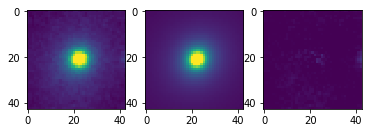

    ID         ra       dec       re   re_err     ar  ar_err       n   n_err  \
1  455  34.422282 -3.763513  58.3945  38.9567  0.867  0.0132  8.0006  1.4512   

       mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
1  20.2758   0.3732 -0.0216   0.0022  1.022178           0  


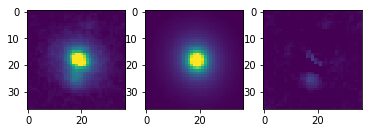

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
2  661  34.434096 -3.757658  4.4956  0.1854  0.8957  0.0099  3.0743  0.1384   

       mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
2  22.0689   0.0269  0.005471  0.00042  0.305518           0  


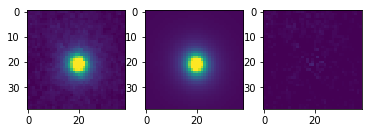

     ID        ra       dec     re  re_err      ar  ar_err       n   n_err  \
3  1036  34.43245 -3.749924  7.635  0.9149  0.5144  0.0085  5.0309  0.4047   

       mag  mag_err     sky   sky_err    chi2nu  ErrorValue  
3  21.9548   0.0652 -0.0047  0.000743  0.393766           0  


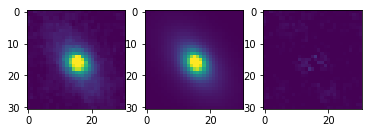

    ID         ra       dec      re  re_err      ar  ar_err      n   n_err  \
4  300  34.435031 -3.767948  2.2217  0.0403  0.7417  0.0139  2.574  0.1577   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
4  22.4572   0.0155  0.000867  0.000386  0.477339           0  


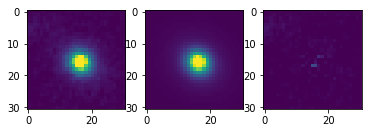

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
5  920  34.435628 -3.753143  2.0608  0.5989  0.8615  0.0281  9.6596  2.6892   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
5  22.3533    0.134 -0.002801  0.001403  0.553312           0  


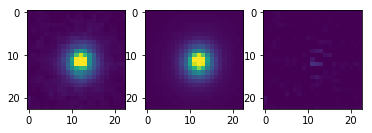

    ID         ra       dec       re   re_err      ar  ar_err        n  \
6  305  34.447153 -3.768007  33.0474  18.1894  0.4051  0.0085  11.2109   

    n_err      mag  mag_err       sky   sky_err   chi2nu  ErrorValue  
6  1.9749  21.5549   0.2298 -0.004301  0.000821  0.31243          16  


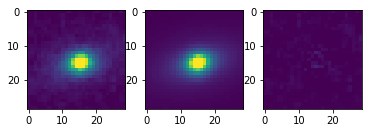

     ID         ra       dec      re  re_err     ar  ar_err       n   n_err  \
7  1057  34.436886 -3.750173  3.3123  0.0364  0.512  0.0081  1.6321  0.0645   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  22.7747   0.0097  0.000222  0.000191  0.254961           0  


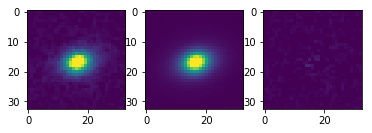

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
8  1065  34.435917 -3.749538  4.5865  0.3128  0.3704  0.0405  0.9374  0.2062   

       mag  mag_err    sky  sky_err   chi2nu  ErrorValue  
8  22.7974   0.0418  0.018   0.0009  16.4658           0  


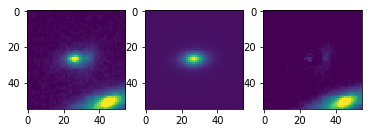

    ID        ra       dec      re  re_err      ar  ar_err       n   n_err  \
9  608  34.43845 -3.760699  2.4748   0.033  0.7395  0.0117  1.2098  0.0633   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
9  22.8834   0.0075 -0.001608  0.000237  0.364514           0  


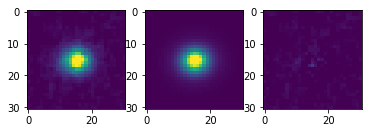

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
10  243  34.422417 -3.770003  2.3622    0.04  0.5984  0.0127  2.1707  0.1341   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
10  22.5412   0.0137 -0.000624  0.000388  0.422937           0  


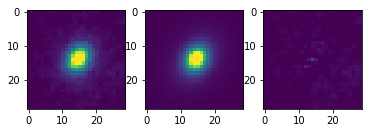

     ID         ra       dec        re    re_err      ar  ar_err        n  \
11  644  34.433802 -3.758806  164.7742  802.1895  0.5152  0.0404  15.6649   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
11  15.6956  21.5277   1.9587  0.0158    0.002  1.634471          16  


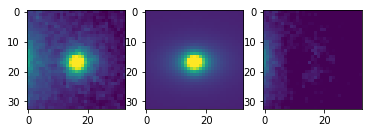

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
12  847  34.434697 -3.754887  1.7601  0.0445  0.8436  0.0203  1.9367  0.1745   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
12  23.3887   0.0162  0.002131  0.000268  0.272354           0  


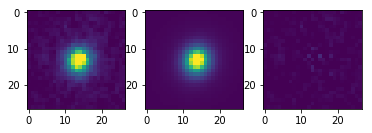

     ID         ra       dec   re  re_err      ar  ar_err       n   n_err  \
13  375  34.444096 -3.765667  9.1   2.241  0.8015  0.0177  4.4875  0.6323   

       mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
13  22.548   0.1498 -0.00172  0.000819  0.266649           0  


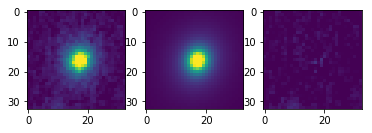

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
14  735  34.425011 -3.758034  2.7416  0.0741  0.4809  0.0144  2.5999  0.1981   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
14  23.211    0.021 -0.002149  0.000269  0.261132           0  


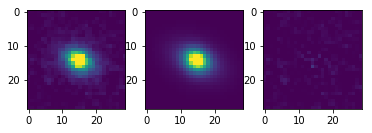

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
15  1223  34.443347 -3.745001  1.4219  0.0387  0.7848  0.0211  2.1902  0.2149   

        mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
15  23.3667   0.0147 -0.00089  0.000284  0.270796           0  


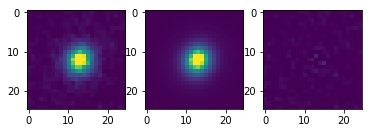

     ID         ra       dec      re  re_err    ar  ar_err      n   n_err  \
16  347  34.441846 -3.766667  4.4635  0.2679  0.66  0.0185  2.055  0.1856   

        mag  mag_err       sky  sky_err   chi2nu  ErrorValue  
16  23.3954   0.0457 -0.000567  0.00035  0.29589           0  


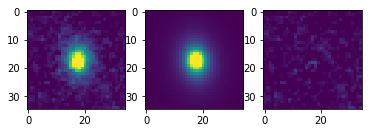

     ID         ra       dec      re  re_err      ar  ar_err       n  n_err  \
17  146  34.444783 -3.772856  7.0998  0.0911  0.4877  0.0056  0.8994  0.027   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
17  22.8458   0.0083 -0.001249  0.000087  0.313035           0  


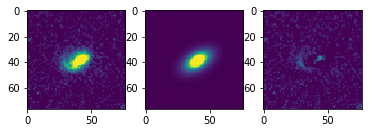

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
18  497  34.433001 -3.763179  3.2202  0.5304  0.9952   0.029  4.1534  0.6712   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
18  23.1779   0.0958 -0.003406  0.000751  0.276813           0  


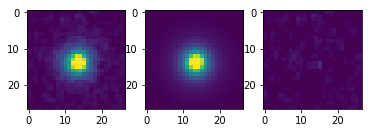

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
19  604  34.439389 -3.760298  8.4508   0.078  0.2357  0.0039  0.3697  0.0212   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
19  23.3059   0.0084 -0.001537  0.00006  0.263089           0  


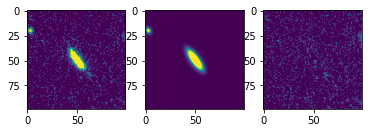

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
20  1147  34.433624 -3.747747  1.6791  0.0477  0.6084  0.0235  0.8627  0.1467   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
20  23.8429   0.0093  0.002666  0.000285  0.391478           0  


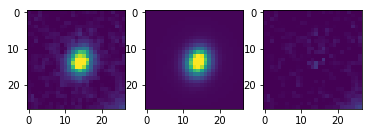

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
21  407  34.446407 -3.765319  4.9984  0.4288  0.4922  0.0182  2.7526  0.3034   

        mag  mag_err      sky   sky_err    chi2nu  ErrorValue  
21  23.2205   0.0565 -0.00283  0.000307  0.455458           0  


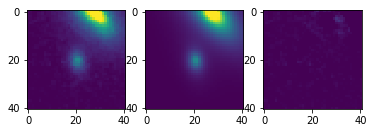

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
22  731  34.439754 -3.758259  1.4761  0.0496  0.6853  0.0279  1.9274  0.2479   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
22  23.7861   0.0161 -0.002598  0.00025  0.269558           0  


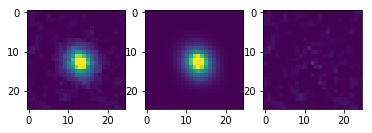

     ID         ra       dec       re    re_err      ar  ar_err        n  \
23  653  34.433963 -3.759267  28.3481  103.8835  0.6027  0.0586  15.8383   

      n_err      mag  mag_err     sky  sky_err    chi2nu  ErrorValue  
23  17.0176  22.8625   1.2796  0.0148   0.0012  0.741288          16  


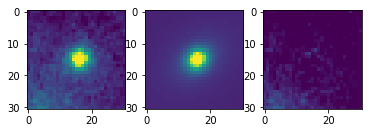

     ID         ra      dec      re  re_err     ar  ar_err       n   n_err  \
24  469  34.418647 -3.76372  2.7175   3.047  0.864  0.0906  8.5977  7.4738   

        mag  mag_err       sky   sky_err   chi2nu  ErrorValue  
24  23.8181   0.4983 -0.000071  0.001274  0.46085           0  


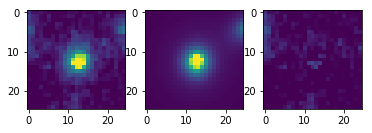

     ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
25  726  34.430604 -3.757624  10.4533  0.3099  0.7094  0.0134  1.0001  0.0401   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
25  23.2616   0.0232 -0.001143  0.000062  0.276562           0  


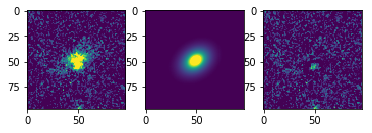

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
26  232  34.440507 -3.770359  4.5455  0.1223  0.5849  0.0161  1.0604  0.0615   

      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
26  23.87   0.0192 -0.001325  0.000124  0.263507           0  


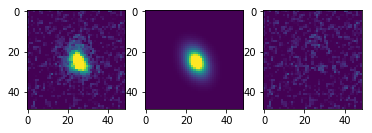

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
27  454  34.418951 -3.763868  7.2194  0.1299  0.6032  0.0104  0.4462  0.0312   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
27  23.6148   0.0132 -0.001844  0.000085  0.297494           0  


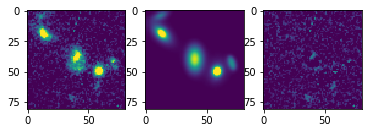

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
28  808  34.447713 -3.756092  7.1903  0.1554  0.3752  0.0081  0.7519  0.0476   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
28  23.8187    0.014  0.001324  0.000076  0.251762           0  


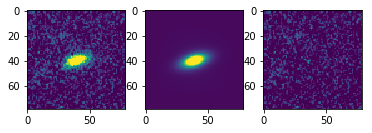

     ID        ra       dec      re  re_err      ar  ar_err       n   n_err  \
29  240  34.45158 -3.770285  6.2574  0.1776  0.4466  0.0109  1.2056  0.0587   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
29  22.888   0.0211 -0.000592  0.000225  0.252314           0  


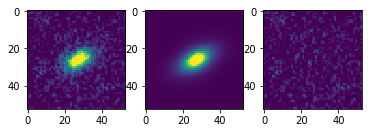

     ID         ra       dec     re  re_err     ar  ar_err       n  n_err  \
30  554  34.435274 -3.762475  4.915  0.0798  0.259  0.0113  0.3558  0.045   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
30  23.8873    0.012 -0.000325  0.000126  0.381269           0  


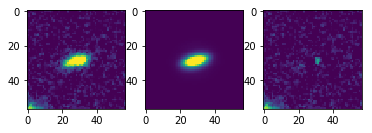

     ID         ra       dec      re  re_err      ar  ar_err      n   n_err  \
31  334  34.427611 -3.767412  3.2758  0.0617  0.3407  0.0167  0.215  0.0596   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
31  24.2432   0.0095 -0.001714  0.000149  0.252869           0  


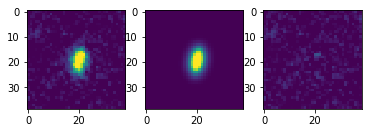

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
32  1127  34.438735 -3.748219  3.0917  0.1798  0.6689  0.0329  1.9576  0.2922   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
32  24.2148   0.0466 -0.001241  0.00021  0.262984           0  


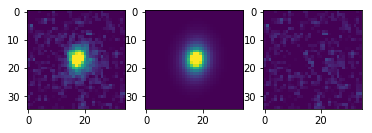

     ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
33  525  34.418961 -3.762811  4.0762  0.1191  0.3527  0.0226  0.3243  0.0835   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
33  24.3852   0.0187 -0.001514  0.000191  0.508965           0  


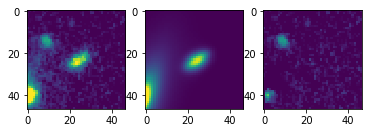

     ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
34  434  34.446607 -3.764467  12.1055  1.3054  0.3985  0.0144  2.6135  0.2527   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
34  23.4476   0.0739 -0.001211  0.00012  0.259161           0  


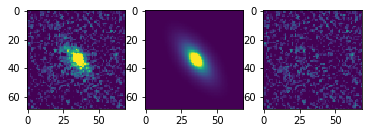

     ID         ra       dec      re  re_err     ar  ar_err       n   n_err  \
35  266  34.421055 -3.769239  5.5744  0.1587  0.253  0.0118  0.9472  0.0836   

        mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
35  24.0633    0.017 -0.002427  0.000101  0.285801           0  


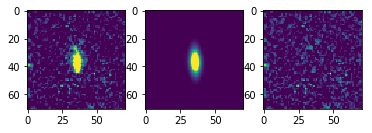

      ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
36  1257  34.446333 -3.743596  7.6353  0.3014  0.6304  0.0204  0.8331  0.0684   

        mag  mag_err       sky  sky_err    chi2nu  ErrorValue  
36  23.7344   0.0278 -0.000978   0.0001  0.287885           0  


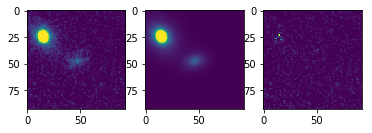

In [53]:
# Plot fits by ID
for ID in fit_df['ID']:
    gfh.plot_by_ID(ID,save_name=savename,survey='HST')

### Compare Stellar vs. 3DHST PSF

In [7]:
DHST_results_filename = '/data/emiln/XLSSC122_GalPops/Analysis/HST/Results/XLSSC122_3DHSTPSF_data_cps_sigma_rms_cps_w5HLR_3DHST_F140W_PSF_5min_CONV128_CONSTR_DYNMAG.csv'
stellar_results_filename = '/data/emiln/XLSSC122_GalPops/Analysis/HST/Results/XLSSC122_3ARCSEC_STELLAR_PSF_data_cps_sigma_rms_cps_w5HLR_639_3arcsec_PSF_5min_CONV128_CONSTR_DYNMAG.csv'

dhst_df = pd.read_csv(DHST_results_filename)
stellar_df = pd.read_csv(stellar_results_filename)



Text(0,0.5,'$r_e$ 3DHST PSF')

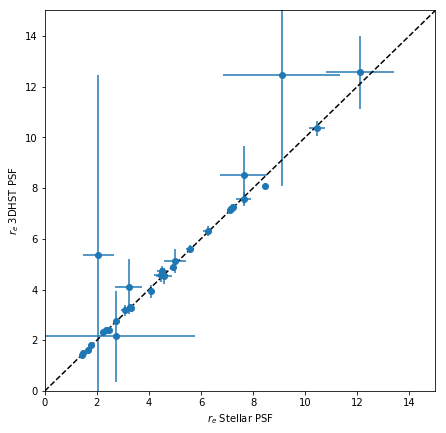

In [8]:
# plt.scatter(stellar_df['re'],dhst_df['re'])
plt.figure(figsize=(7,7))
plt.errorbar(stellar_df['re'],dhst_df['re'],xerr=stellar_df['re_err'],yerr=dhst_df['re_err'],fmt='o')
plt.xlim(0,15)
plt.ylim(0,15)
# plt.grid(True)
plt.plot([0,200],[0,200],'--k')
plt.xlabel('$r_e$ Stellar PSF')
plt.ylabel('$r_e$ 3DHST PSF')

Text(0,0.5,'$r_e$ 3DHST PSF')

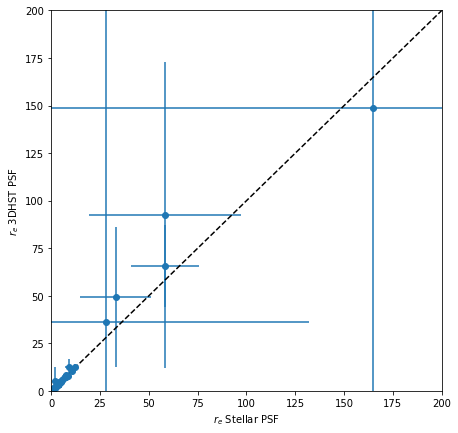

In [9]:
plt.figure(figsize=(7,7))
plt.errorbar(stellar_df['re'],dhst_df['re'],xerr=stellar_df['re_err'],yerr=dhst_df['re_err'],fmt='o')
plt.xlim(0,200)
plt.ylim(0,200)
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(True)
plt.plot([0,200],[0,200],'--k')
plt.xlabel('$r_e$ Stellar PSF')
plt.ylabel('$r_e$ 3DHST PSF')

### Refit large error objects with larger cutout

In [10]:
large_err_df = dhst_df[dhst_df['re_err']/dhst_df['re']>0.2]
large_err_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,mag_err,sky,sky_err,chi2nu,ErrorValue
0,529,34.434215,-3.758796,65.7991,21.5265,0.8797,0.0071,7.0077,0.6289,19.9677,0.1996,0.002517,0.001281,0.377765,0
1,455,34.422282,-3.763513,92.5058,80.1740,0.8402,0.0131,9.0613,1.8917,20.0301,0.4724,-0.022500,0.002400,1.037686,0
5,920,34.435628,-3.753143,5.3473,7.1281,0.7731,0.0286,20.0000,12.7589,21.9725,0.4280,-0.004682,0.001862,0.630946,16
6,305,34.447153,-3.768007,49.5238,36.8960,0.4244,0.0086,12.9276,2.6993,21.3759,0.2984,-0.004755,0.000874,0.294775,16
11,644,34.433802,-3.758806,148.8870,756.2783,0.5486,0.0429,15.2951,16.2957,21.5391,2.0577,0.015700,0.002200,1.658071,16
13,375,34.444096,-3.765667,12.4408,4.3688,0.7857,0.0174,5.3547,0.8946,22.3608,0.2032,-0.002461,0.000902,0.259584,0
18,497,34.433001,-3.763179,4.1181,1.1020,0.9341,0.0283,5.2409,1.0685,23.0441,0.1420,-0.004111,0.000874,0.268964,0
23,653,34.433963,-3.759267,36.1491,169.4337,0.6284,0.0615,17.2905,22.0779,22.7623,1.5863,0.014800,0.001300,0.751587,16
24,469,34.418647,-3.763720,2.1493,1.8094,0.7310,0.0849,8.3549,7.1541,23.9130,0.4071,0.000577,0.001109,0.437558,0


In [14]:
fit_df = member_df[member_df['ID'].isin(large_err_df['ID'])]
print len(fit_df)
# df_name = 'XLSSC122_3DHSTPSF'
# df_name = 'TEMP_TEST'
df_name = 'LARGE_ERR_3ARCSEC_STELLAR_PSF'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/HST/Products/PSF/'
# psf_file = psf_root+'cosmos_3dhst.v4.0.F140W_psf.fits' # Filename causes galfit to seg fault
# psf_file = psf_root+'3DHST_F140W_PSF.fits'
psf_file = psf_root+'639_3arcsec_PSF.fits'
# psf_file = psf_root+'639_70pix_PSF.fits'
PSFf = 1 
convbox='128 128'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=5*60
verbose=True
width=10
HLRwidth=20 # Cutout width = 2*HLRwidth
PA_INIT = 45
AR_INIT = 0.5
ZP = 26.465 # https://iopscience.iop.org/article/10.1088/0067-0049/214/2/24/pdf page 13, page 20 --> All cataloged fluxes are normalized to AB zero point = 25
# ZP = 25
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=3
DYNMAG = True
sky='Default'
sky_INIT=0.00001
sigma_file = '/sigma_rms_cps.fits'
data_file = '/data_cps.fits'
constraint_file = '/data/emiln/XLSSC122_GalPops/Analysis/galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

9


In [15]:
params = {
    'survey':'HST',
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

In [16]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

e: 27.51
Neighbour mag too faint, not being fit
NEIGHBOUR initialized with magnitude: 27.83
Neighbour mag too faint, not being fit
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/HST/galfit_results/305
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/HST/galfit_results/455
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/HST/galfit_results/920
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/HST/galfit_results/529
SAVE_NAME:LARGE_ERR_3ARCSEC_STELLAR_PSF_data_cps_sigma_rms_cps_w20HLR_639_3arcsec_PSF_5min_CONV128_CONSTR_DYNMAG
1_XC 401.2949 +/- 0.0121
1_YC 400.9499 +/- 0.0126
1_MAG 22.5358 +/- 0.0168
1_RE 1.4499 +/- 0.0395
1_N 6.3884 +/- 0.4414
1_AR 0.8452 +/- 0.0179
1_PA 11.7539 +/- 4.0510
2_XC [400.0000]
2_YC [400.0000]
2_SKY -2.551e-04 +/- 7.252e-05
2_DSDX [0.000e+00]
2_DSDY [0.000e+00]
**** 920 ****
[{'1_RE': '1.4499 +/- 0.0395', '1_N': '6.3884 +/- 0.4414', '1_MAG': '22.5358 +/- 0.0168', '1_YC': '4

### Validate new fits

In [17]:
new_df

,ID,ra,dec,re,re_err,ar,ar_err,n,n_err,mag,mag_err,sky,sky_err,chi2nu,ErrorValue
0,529,34.434215,-3.758796,96.2689,11.8374,0.8192,0.0056,7.5569,0.2702,19.7563,0.0679,-0.000442,0.000107,0.418440,0
1,455,34.422282,-3.763513,4.6240,0.0721,0.9368,0.0087,2.9442,0.0643,21.7323,0.0090,-0.001806,0.000056,0.469644,0
2,920,34.435628,-3.753143,1.4499,0.0395,0.8452,0.0179,6.3884,0.4414,22.5358,0.0168,-0.000255,0.000073,0.293064,0
3,305,34.447153,-3.768007,11.3433,0.9366,0.4094,0.0070,7.3004,0.3759,22.0240,0.0358,-0.002075,0.000056,0.263024,0
4,644,34.433802,-3.758806,2.5159,0.0001,0.8568,0.0000,2.0915,0.0001,23.4352,0.0000,-0.000275,0.000058,0.379382,0
5,375,34.444096,-3.765667,5.1813,0.1952,0.8496,0.0173,2.8866,0.1237,22.8787,0.0219,-0.000832,0.000053,0.321775,0
6,497,34.433001,-3.763179,2.2093,0.0518,0.9806,0.0231,2.4437,0.1681,23.4293,0.0132,-0.001083,0.000059,0.285403,0
7,653,34.433963,-3.759267,2.7330,0.1905,0.7094,0.0330,4.1513,0.5636,23.7874,0.0411,-0.000845,0.000133,0.302613,0
8,469,34.418647,-3.763720,2.3689,0.2696,0.7414,0.0356,5.1041,1.0718,23.9247,0.0662,-0.001887,0.000074,0.286499,0


    ID         ra       dec       re   re_err      ar  ar_err       n   n_err  \
0  529  34.434215 -3.758796  96.2689  11.8374  0.8192  0.0056  7.5569  0.2702   

       mag  mag_err       sky   sky_err   chi2nu  ErrorValue  
0  19.7563   0.0679 -0.000442  0.000107  0.41844           0  


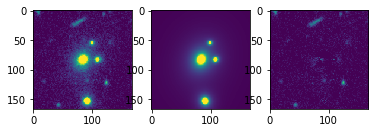

    ID         ra       dec     re  re_err      ar  ar_err       n   n_err  \
1  455  34.422282 -3.763513  4.624  0.0721  0.9368  0.0087  2.9442  0.0643   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
1  21.7323    0.009 -0.001806  0.000056  0.469644           0  


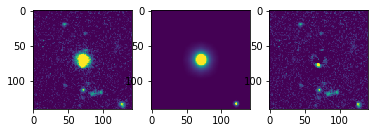

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
2  920  34.435628 -3.753143  1.4499  0.0395  0.8452  0.0179  6.3884  0.4414   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
2  22.5358   0.0168 -0.000255  0.000073  0.293064           0  


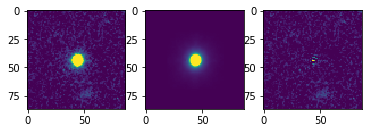

    ID         ra       dec       re  re_err      ar  ar_err       n   n_err  \
3  305  34.447153 -3.768007  11.3433  0.9366  0.4094   0.007  7.3004  0.3759   

      mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
3  22.024   0.0358 -0.002075  0.000056  0.263024           0  


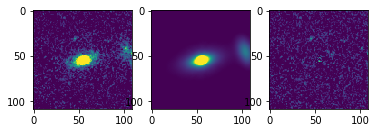

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
4  644  34.433802 -3.758806  2.5159  0.0001  0.8568     0.0  2.0915  0.0001   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
4  23.4352      0.0 -0.000275  0.000058  0.379382           0  


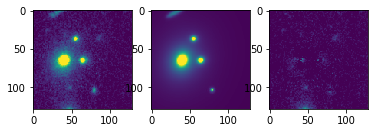

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
5  375  34.444096 -3.765667  5.1813  0.1952  0.8496  0.0173  2.8866  0.1237   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
5  22.8787   0.0219 -0.000832  0.000053  0.321775           0  


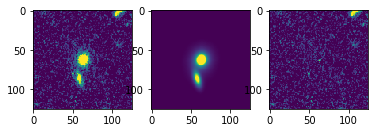

    ID         ra       dec      re  re_err      ar  ar_err       n   n_err  \
6  497  34.433001 -3.763179  2.2093  0.0518  0.9806  0.0231  2.4437  0.1681   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
6  23.4293   0.0132 -0.001083  0.000059  0.285403           0  


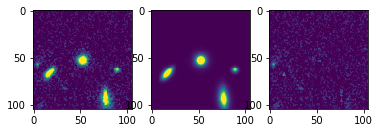

    ID         ra       dec     re  re_err      ar  ar_err       n   n_err  \
7  653  34.433963 -3.759267  2.733  0.1905  0.7094   0.033  4.1513  0.5636   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
7  23.7874   0.0411 -0.000845  0.000133  0.302613           0  


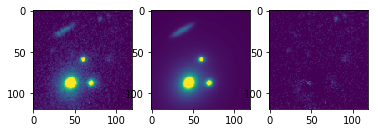

    ID         ra      dec      re  re_err      ar  ar_err       n   n_err  \
8  469  34.418647 -3.76372  2.3689  0.2696  0.7414  0.0356  5.1041  1.0718   

       mag  mag_err       sky   sky_err    chi2nu  ErrorValue  
8  23.9247   0.0662 -0.001887  0.000074  0.286499           0  


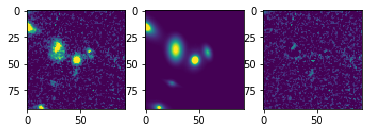

In [18]:
# Plot fits by ID
for ID in fit_df['ID']:
    gfh.plot_by_ID(ID,save_name=savename,survey='HST')

### Combine into final catalog

In [29]:
large_cutout_galfit_df = pd.read_csv('/data/emiln/XLSSC122_GalPops/Analysis/HST/Results/LARGE_ERR_3ARCSEC_STELLAR_PSF_data_cps_sigma_rms_cps_w20HLR_639_3arcsec_PSF_5min_CONV128_CONSTR_DYNMAG.csv')
hst_galfit_df = pd.read_csv( '/data/emiln/XLSSC122_GalPops/Analysis/HST/Results/XLSSC122_3DHSTPSF_data_cps_sigma_rms_cps_w5HLR_3DHST_F140W_PSF_5min_CONV128_CONSTR_DYNMAG.csv')

In [32]:
combined_df = hst_galfit_df.set_index('ID')
large_cutout_galfit_df = large_cutout_galfit_df.set_index('ID')
combined_df.update(large_cutout_galfit_df)


In [34]:
save_file = '/data/emiln/XLSSC122_GalPops/Analysis/HST/Results/final_galfit.csv'
combined_df.to_csv(save_file)